This is a notebook to explore how to plot with time dependent depths.

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

from salishsea_tools import viz_tools, grid_tools

%matplotlib inline

# Loading data

In [2]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

bathy = grid.variables['Bathymetry'][:]
# Sample file for testing calculations
fT = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_T.nc')

In [3]:
tmask = mesh_mask.variables['tmask'][:]
e3t_0 = mesh_mask.variables['e3t'][:]
gdept_0 = mesh_mask.variables['gdept'][:]
gdepw_0 = mesh_mask.variables['gdepw'][:]

In [4]:
ssh = fT.variables['sossheig'][:]
sal = fT.variables['vosaline'][:]

In [5]:
grids = grid_tools.calculate_vertical_grids(e3t_0[0,...], tmask[0,...], ssh, return_vars=['gdept_t', 
                                                                                          'gdepw_t']
                                           )

/data/nsoontie/MEOPAR/tools/SalishSeaTools/salishsea_tools/grid_tools.py:48: RuntimeWarning: invalid value encountered in true_divide
  mu = sum_matrix/vn


# Plotting
Sample position

In [6]:
sal_m = np.ma.array(sal, mask = np.ones(sal.shape) - tmask)

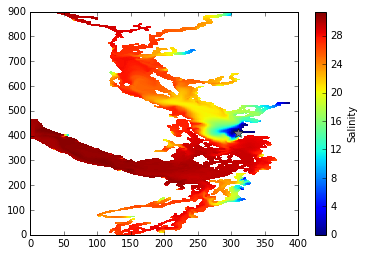

In [7]:
j=410
i=310
plt.pcolormesh(sal_m[0,0,:,:])
cbar=plt.colorbar()
cbar.set_label("Salinity")
plt.plot(i,j,'*',color='gray',ms=10)

## 1. Treating depth as a pressure
First, experiment plotting when depth is treated as a pressure. That is, the surface (first w point) always has depth 0. This means, the bottom depth changes with the sea surface height, just has the bottom pressure would.

Plotting with Height instead of depth. Height increases from bottom to top, wheras depth decreases from bottom to top. So Height = -depth

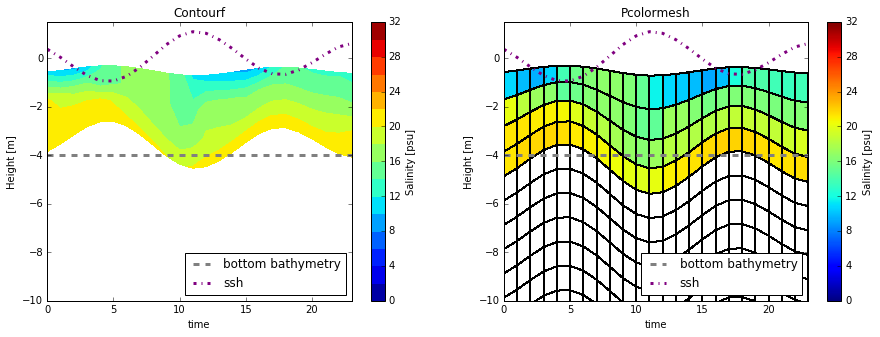

In [8]:
time,_ = np.meshgrid(np.arange(sal.shape[0]),gdept_0[0,:,j,i])
fig,axs = plt.subplots(1,2,figsize=(15,5))
smin=0
smax=32
levels= np.arange(smin,smax+2,2)
#contourf
ax=axs[0]
mesh =ax.contourf(time.T,-grids['gdept_t'][:,:,j,i],
                  sal_m[:,:,j,i], levels)
ax.set_title('Contourf')
cbar=plt.colorbar(mesh, ax=ax)
cbar.set_label('Salinity [psu]')
ax=axs[1]
mesh =ax.pcolormesh(time.T,-grids['gdept_t'][:,:,j,i],
                    sal_m[:,:,j,i],
                    edgecolors='k', vmin=smin, vmax=smax)
ax.set_title('Pcolormesh')
cbar=plt.colorbar(mesh, ax=ax)
cbar.set_label('Salinity [psu]')
for ax in axs:
    ax.set_ylim([-10,1.5])
    ax.set_xlim([0,23])
    ax.set_ylabel('Height [m]')
    ax.set_xlabel('time')
    ax.plot([0,24],[-bathy[j,i],-bathy[j,i]], '--', color='gray', lw=3, label='bottom bathymetry')
    ax.plot(ssh[:,j,i],'-.',color='purple',label='ssh',lw=3)
    ax.legend(loc=4)

Seems to make sense. Lower pressure when ssh is negative, higher when ssh is positive.

## 2. Depth with ssh removed

Next, think of depth measured relative to ssh = 0. Just subtract sea surface height from depth variable and multiply the result by -1 to get height.

### Using gdept

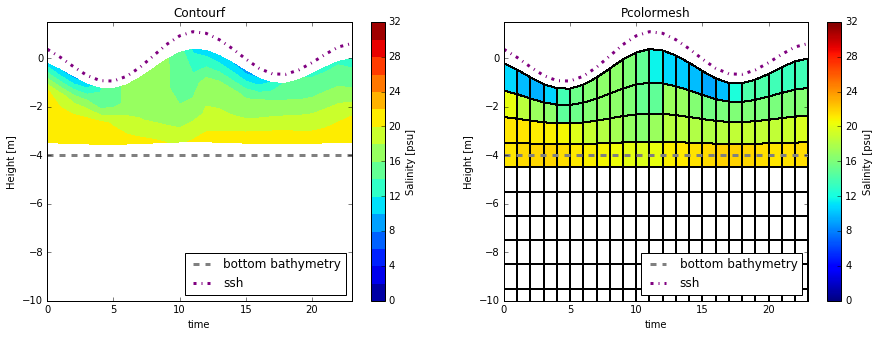

In [9]:
time,_ = np.meshgrid(np.arange(sal.shape[0]),gdept_0[0,:,j,i])
fig,axs = plt.subplots(1,2,figsize=(15,5))
smin=0
smax=32
levels= np.arange(smin,smax+2,2)
#contourf
ax=axs[0]
mesh =ax.contourf(time.T,-grids['gdept_t'][:,:,j,i]+  np.expand_dims(ssh[:,j,i],axis=1),
                   sal_m[:,:,j,i], levels)
ax.set_title('Contourf')
cbar=plt.colorbar(mesh, ax=ax)
cbar.set_label('Salinity [psu]')
ax=axs[1]
mesh =ax.pcolormesh(time.T,-grids['gdept_t'][:,:,j,i] +np.expand_dims(ssh[:,j,i],axis=1),
                    sal_m[:,:,j,i], edgecolors='k',  vmin=smin, vmax=smax)
ax.set_title('Pcolormesh')
cbar=plt.colorbar(mesh, ax=ax)
cbar.set_label('Salinity [psu]')
for ax in axs:
    ax.set_ylim([-10,1.5])
    ax.set_xlim([0,23])
    ax.set_ylabel('Height [m]')
    ax.set_xlabel('time')
    ax.plot([0,24],[-bathy[j,i],-bathy[j,i]], '--', color='gray', lw=3,label='bottom bathymetry')
    ax.plot(ssh[:,j,i],'-.',color='purple',label='ssh',lw=3)
    ax.legend(loc=4)

Interesting that the colors extend below the bottom bathymetry with pcolormesh but not with contourf. I think it is because of how pcolormesh decides to color each box. It colors each cell with the data value at the bottom left corner the coordinate arrays. This explains why we don't align with the surface and bottom. 

Contourf doens't fill the bottom row because the level below is masked.

### Using gdepw

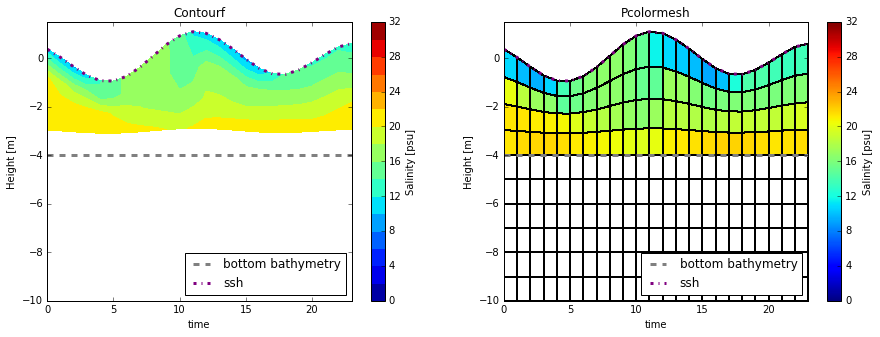

In [10]:

time,_ = np.meshgrid(np.arange(sal.shape[0]),gdept_0[0,:,j,i])
fig,axs = plt.subplots(1,2,figsize=(15,5))
smin=0
smax=32
levels= np.arange(smin,smax+2,2)
#contourf
ax=axs[0]
mesh =ax.contourf(time.T,-grids['gdepw_t'][:,:,j,i]+  np.expand_dims(ssh[:,j,i],axis=1),
                   sal_m[:,:,j,i], levels)
ax.set_title('Contourf')
cbar=plt.colorbar(mesh, ax=ax)
cbar.set_label('Salinity [psu]')
ax=axs[1]
mesh =ax.pcolormesh(time.T,-grids['gdepw_t'][:,:,j,i] +np.expand_dims(ssh[:,j,i],axis=1),
                    sal_m[:,:,j,i], edgecolors='k',  vmin=smin, vmax=smax)
ax.set_title('Pcolormesh')
cbar=plt.colorbar(mesh, ax=ax)
cbar.set_label('Salinity [psu]')
for ax in axs:
    ax.set_ylim([-10,1.5])
    ax.set_xlim([0,23])
    ax.set_ylabel('Height [m]')
    ax.set_xlabel('time')
    ax.plot([0,24],[-bathy[j,i],-bathy[j,i]], '--', color='gray', lw=3,label='bottom bathymetry')
    ax.plot(ssh[:,j,i],'-.',color='purple',label='ssh',lw=3)
    ax.legend(loc=4)

Plotting with pcolormesh and gdepw gives alignment with the sea surface height and bottom. The centre of the grid cell represents the T-point and the edges are the w-points.  

Again, contourf doesn't fill the bottom cells because the next level is masked. In the thalweg plots, we handle this by filling the next row with the value above.